# Tesla Stock Price Prediction, 365 All At Once
### Second Semester Capstone


In [226]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [227]:
# Loading Preprocessed Data File
df = pd.read_csv("../Data/preprocessed.csv",usecols=['Date','Close','Tesla Trend','Month','Day of the Month','Day of the Week'], parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)

print(df.shape)
df.head()

(2699, 5)


,Close,Tesla Trend,Month,Day of the Month,Day of the Week
Date,,,,,
2010-07-01,4.392,7.00,7,1,3
2010-07-02,3.840,6.09,7,2,4
2010-07-06,3.222,2.10,7,6,1
2010-07-07,3.160,3.78,7,7,2
2010-07-08,3.492,5.60,7,8,3


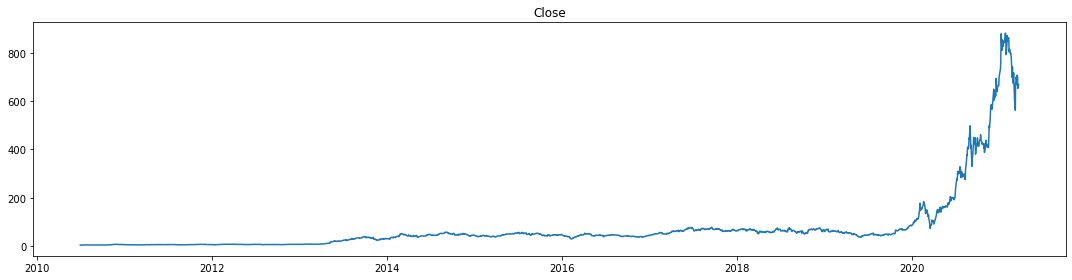

In [228]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(15,4))

pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")

pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [229]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Converting Data for Supervised Learning

In [230]:
from sklearn.preprocessing import MinMaxScaler

n_in = 90
n_out = 90

values = df.values
# integer encoding of labels (not using yet here since we don't have non-numerical data)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, n_in, n_out)

# Drop Columns of Variables We Aren't Predicting
# We want only the variable we're predicting for time t
for i in range(1, 90):
    reframed.drop(reframed.loc[:, ('Tesla Trend(t+%i)' %(i)):('Day of the Week(t+%i)' %(i))], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Tesla Trend(t)':'Day of the Week(t)'], axis=1, inplace=True)

print(reframed.shape)
reframed.head()

(2520, 540)


,Close(t-90),Tesla Trend(t-90),Month(t-90),Day of the Month(t-90),Day of the Week(t-90),Close(t-89),Tesla Trend(t-89),Month(t-89),Day of the Month(t-89),Day of the Week(t-89),...,Close(t+80),Close(t+81),Close(t+82),Close(t+83),Close(t+84),Close(t+85),Close(t+86),Close(t+87),Close(t+88),Close(t+89)
90,0.001400,0.060606,0.545455,0.000000,0.75,0.000773,0.051414,0.545455,0.033333,1.00,...,0.002080,0.002077,0.002014,0.002027,0.001866,0.001880,0.001693,0.001625,0.001596,0.001593
91,0.000773,0.051414,0.545455,0.033333,1.00,0.000070,0.011111,0.545455,0.166667,0.25,...,0.002077,0.002014,0.002027,0.001866,0.001880,0.001693,0.001625,0.001596,0.001593,0.001627
92,0.000070,0.011111,0.545455,0.166667,0.25,0.000000,0.028081,0.545455,0.200000,0.50,...,0.002014,0.002027,0.001866,0.001880,0.001693,0.001625,0.001596,0.001593,0.001627,0.001575
93,0.000000,0.028081,0.545455,0.200000,0.50,0.000377,0.046465,0.545455,0.233333,0.75,...,0.002027,0.001866,0.001880,0.001693,0.001625,0.001596,0.001593,0.001627,0.001575,0.001452
94,0.000377,0.046465,0.545455,0.233333,0.75,0.000364,0.037273,0.545455,0.266667,1.00,...,0.001866,0.001880,0.001693,0.001625,0.001596,0.001593,0.001627,0.001575,0.001452,0.001457


In [231]:
y = reframed.iloc[:,n_out*-1:]
x = reframed.iloc[:,:n_out*-1]
x_vals = x.values
y_vals = y.values
# split into train, test, and prediction sets
n_predict = 1 # We are predicting 365 days
n_train = floor((len(x_vals)-n_predict) * 0.80) # 80% of the data is currently used for train (can be adjusted)
# split into input and outputs
train_X, train_y = x_vals[:n_train, :], y_vals[:n_train, :]
test_X, test_y = x_vals[n_train:len(x_vals)-n_predict, :], y_vals[n_train:len(y_vals)-n_predict, :]
predict_X, predict_y = x_vals[len(x_vals)-n_predict:, :], y_vals[len(y_vals)-n_predict:, :]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((n_train, n_in, len(df.columns)))
test_X = test_X.reshape((test_X.shape[0], n_in, len(df.columns)))
predict_X = predict_X.reshape((n_predict, n_in, len(df.columns)))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(2015, 90, 5) (2015, 90) (504, 90, 5) (504, 90) (1, 90, 5) (1, 90)


## Running Model

In [232]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg

"\nclass stopAtLossValue(Callback):\n        def on_batch_end(self, batch, logs={}):\n            THR = 0.009 #Assign THR with the value at which you want to stop training.\n            if logs.get('loss') <= THR:\n                 self.model.stop_training = True\n"

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 150)               93600     
_________________________________________________________________
dense_11 (Dense)             (None, 90)                13590     
Total params: 107,190
Trainable params: 107,190
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
14/14 - 4s - loss: 0.0235 - accuracy: 0.0194 - val_loss: 0.1562 - val_accuracy: 0.0179
Epoch 2/40
14/14 - 2s - loss: 0.0285 - accuracy: 0.0263 - val_loss: 0.1427 - val_accuracy: 0.0159
Epoch 3/40
14/14 - 2s - loss: 0.0263 - accuracy: 0.0134 - val_loss: 0.1416 - val_accuracy: 0.0079
Epoch 4/40
14/14 - 2s - loss: 0.0188 - accuracy: 0.0099 - val_loss: 0.1357 - val_accuracy: 0.0079
Epoch 5/40
14/14 - 2s - loss: 0.0197 - accuracy: 0.0179 - val_loss: 0.1334 - val_accuracy: 0.0139
Epoch 6/40
14/14 - 

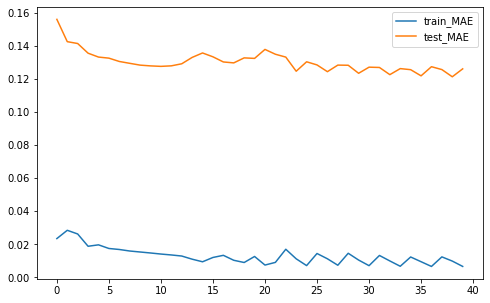

In [233]:
# Design Network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(90, activation="linear", kernel_constraint=NonNeg()))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit network
# epochs = how long you're running it
# batch_size = number of training samples to use in an epoch
history = model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(8,5))
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.show()

### Prediction

In [234]:
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(predict_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(predict_y, yhat))
print('PRE INVERSE TRANSFORM\nTest RMSE: %.3f' % rmse)
normalized_rmse = rmse/(predict_y.mean())
print('Normalized RMSE: %.3f' % normalized_rmse)

scaler.fit(df["Close"][len(dates)-90:].values.reshape(-1,1))
inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(90)
inv_y = scaler.inverse_transform(predict_y).reshape(90)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('POST INVERSE TRANSFORM\nTest RMSE: %.3f' % rmse)
normalized_rmse = rmse/(inv_y.mean())
print('Normalized RMSE: %.3f' % normalized_rmse)


PRE INVERSE TRANSFORM
Test RMSE: 0.614
Normalized RMSE: 0.784
POST INVERSE TRANSFORM
Test RMSE: 291.802
Normalized RMSE: 0.374


### Metrics

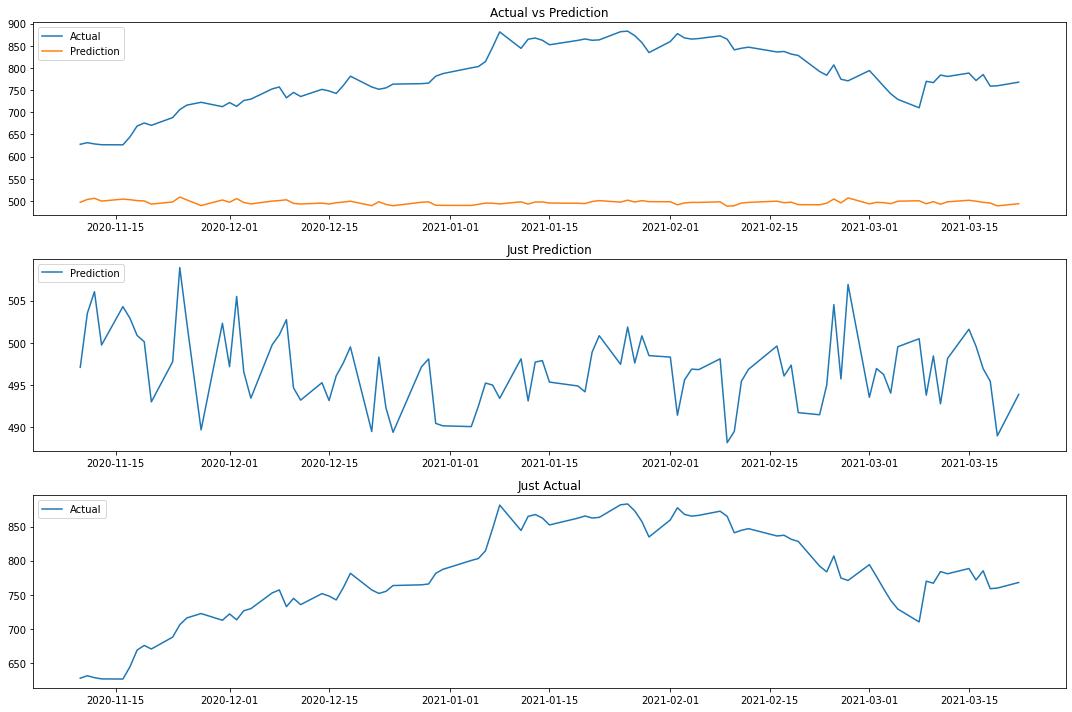

In [235]:
predictDates = dates[len(dates)-90:]
# Plot of Prediction vs Actual
pyplot.figure(figsize=(15,10))

pyplot.subplot(3, 1, 1)
pyplot.plot(predictDates, inv_y, label="Actual")
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.legend(loc='upper left')
pyplot.title("Actual vs Prediction")
pyplot.subplot(3,1,2)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.legend(loc='upper left')
pyplot.title("Just Prediction")
pyplot.subplot(3, 1, 3)
pyplot.plot(predictDates, inv_y, label="Actual")
pyplot.legend(loc='upper left')
pyplot.title("Just Actual")

pyplot.tight_layout()
pyplot.show()